In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('mediamarkt_products.xlsx')

In [3]:
selected_cols = [
    "price", "reviews", "Termék típusa",
    "Operációs rendszer", "Kapacitás", "Memóriaméret",
    "Képernyőátló", "Felbontás szélesség", "Felbontás magasság",
    "Hátsó kamera", "Hátsó kamera felbontás", "Előlapi kamera",
    "Előlapi kamera felbontása", "Arcfelismerés", "Dual SIM",
    "Szélesség", "Magasság", "Mélység",
    "Tömeg", "Akkumulátor kapacitás", #"Modell azonosító",
]

In [4]:
df = df[selected_cols]
df = df.rename(
    columns={
    "Termék típusa":"type",
    "Operációs rendszer":"op",
    "Kapacitás":"capacity",
    "Memóriaméret":"memory",
    "Képernyőátló":"screen_diagonal",
    "Felbontás szélesség":"pixel_w",
    "Felbontás magasság":"pixel_h",
    "Hátsó kamera":"back_camera",
    "Hátsó kamera felbontás":"back_camera_resolution",
    "Előlapi kamera":"front_camera",
    "Előlapi kamera felbontása":"front_camera_resolution",
    "Arcfelismerés":"face_id",
    "Dual SIM":"dual_sim",
    "Szélesség":"w",
    "Magasság":"h",
    "Mélység":"d",
    "Tömeg":"mass",
    "Akkumulátor kapacitás":"battery",
    #"Modell azonosító":"model_id",
    }
)

In [5]:
# Price
df['price'] = df['price'].str.split(',').str[0].astype(int)
df = df.dropna(subset=['price'])

In [6]:
# Reviews
df['reviews'] = df['reviews'].str.split(' ').str[0].astype(int)
df.reviews.isna().sum() # none missing

0

In [7]:
# Type
df.type.unique()

array(['Okostelefon', 'Okostelefon (iPhone 16 Pro Max)',
       'Okostelefon (iPhone 16 Plus)', 'Okostelefon (iPhone 15 Plus)',
       'Okostelefon (iPhone 15)', 'Okostelefon (iPhone 16 Pro)',
       'Okostelefon (iPhone 14)',
       'FM Transzmitter és telefon kihangosító',
       'Okostelefon (iPhone 16)', nan, 'Dect telefon',
       'Vezetékes telefon', 'DECT telefon', 'Samsung Okostelefon'],
      dtype=object)

In [8]:
df['type'] = df['type'].str.lower()
df = df[df['type'].str.contains('okostelefon', case=False, na=False)].copy()

# Step 2: Replace values safely
df.loc[:, 'type'] = df['type'].apply(lambda x: 'iphone' if 'iphone' in x.lower() else 'okostelefon')
df.type = df.type.map({'iphone': 1, 'okostelefon': 0})

In [9]:
df.type.unique()

array([0, 1], dtype=int64)

In [10]:
df.type.isna().sum()

0

In [11]:
# Op rendszer
df = df.drop(['op'], axis=1)
df

,price,reviews,type,capacity,memory,screen_diagonal,pixel_w,pixel_h,back_camera,back_camera_resolution,front_camera,front_camera_resolution,face_id,dual_sim,w,h,d,mass,battery
0,44999,5,0,128 GB,4 GB,17.47 cm,720 pixel,1640 pixel,Dual Cam,50 megapixel,Single Cam,13 megapixel,Igen,Igen,77.8 mm,171.88 mm,8.22 mm,211 g,5160 mAh
1,119999,6,0,256 GB,8 GB,16.94 cm,1080 pixel,2400 pixel,Triple Cam,200 megapixel,Single Cam,32 megapixel,NaN,Igen,74.9 mm,162.2 mm,8.2 mm,180 g,5500 mAh
2,94999,1,0,128 GB,6 GB,17 cm,1080 pixel,2340 pixel,Triple Cam,50 megapixel,Single Cam,13 megapixel,NaN,Nem,77.5 mm,164 mm,7.7 mm,200 g,5000 mAh
3,104999,3,0,256 GB,8 GB,16.94 cm,1080 pixel,2400 pixel,Triple Cam,108 megapixel,Single Cam,20 megapixel,NaN,Igen,75.7 mm,162.4 mm,8 mm,190 g,5110 mAh
4,33999,2,0,64 GB,3 GB,17.47 cm,720 pixel,1640 pixel,Dual Cam,32 megapixel,Single Cam,8 megapixel,Igen,Igen,79.4 mm,173.3 mm,8.26 mm,198 g,5200 mAh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,389999,1,1,128 GB,8 GB,17 cm,1290 pixel,2796 pixel,Dual Cam,48 megapixel,Single Cam,12 megapixel,Igen,Nem,77.8 mm,160.9 mm,7.8 mm,199 g,4006 mAh
236,394999,11,1,256 GB,6 GB,17 cm,1290 pixel,2796 pixel,Dual Cam,48 megapixel,Single Cam,12 megapixel,Igen,Nem,77.8 mm,160.9 mm,7.8 mm,0.201 kg,NaN
237,349999,11,1,128 GB,6 GB,17 cm,1290 pixel,2796 pixel,Dual Cam,48 megapixel,Single Cam,12 megapixel,Igen,Nem,77.8 mm,160.9 mm,7.8 mm,0.201 kg,NaN
238,233999,0,0,512 GB,12 GB,16.94 cm,1220 pixel,2712 pixel,Triple Cam,50 megapixel,Single Cam,50 megapixel,NaN,Nem,73.06 mm,160.69 mm,8.24 mm,186 g,6000 mAh


In [12]:
# Capacity
df.capacity.unique()

array(['128 GB', '256 GB', '64 GB', '1 TB', '512 GB', '16 GB'],
      dtype=object)

In [13]:
df = df.replace({'capacity': {'1 TB': '1024 GB'}})
df['capacity'] = df['capacity'].str.split(' ').str[0].astype(int)

In [14]:
df.capacity.isna().sum()

0

In [15]:
# Memory
df.memory.unique()

array(['4 GB', '8 GB', '6 GB', '3 GB', '12 GB', '16 GB', '2 GB', '1 GB'],
      dtype=object)

In [16]:
df['memory'] = df['memory'].str.split(' ').str[0].astype(int)

In [17]:
df.memory.isna().sum()

0

In [18]:
# Screen diagonal
df.screen_diagonal.unique()

array(['17.47 cm', '16.94 cm', '17 cm', '17.5 cm', '16.71 cm', '17.19 cm',
       '17.01 cm', '17.3 cm', '15.75 cm', '16.63 cm', '17.35 cm',
       '17.27 cm', '16.76 cm', '16.15 cm', '15.49 cm', '16 cm',
       '15.74 cm', '16.6 cm', '17.22 cm', '17.4 cm', '17.78 cm',
       '19.3 cm', '15.24 cm', '16.9 cm', '17.1 cm', '20.11 cm', '17.2 cm',
       '12.7 cm', '16.56 cm', '14.4 cm', '16.51 cm', '17.17 cm',
       '17.20 cm', '16.96 cm', '17.06 cm', '16.25 cm', '20.32 cm',
       '17.07 cm', '17.14 cm'], dtype=object)

In [19]:
df['screen_diagonal'] = df['screen_diagonal'].str.split(' ').str[0].astype(float)

In [20]:
df['screen_diagonal'].isna().sum()

0

In [21]:
# Pixel width & height
df = df.dropna(subset=['pixel_w', 'pixel_h'])
df['pixel_w'] = df['pixel_w'].str.split(' ').str[0].astype(int)
df['pixel_h'] = df['pixel_h'].str.split(' ').str[0].astype(int)

In [22]:
# Back camera & resolution

In [23]:
df.back_camera.unique()

array(['Dual Cam', 'Triple Cam', 'Quad Cam', 'Single Cam'], dtype=object)

In [24]:
df.back_camera = df.back_camera.map({'Single Cam': 1, 'Dual Cam': 2, 'Triple Cam': 3, 'Quad Cam': 4})

In [25]:
df.back_camera.isna().sum()

0

In [26]:
df.back_camera_resolution.isna().sum()

1

(array([ 19.,   9., 159.,   0.,   0.,  25.,   0.,   0.,   0.,  18.]),
 array([  5. ,  24.5,  44. ,  63.5,  83. , 102.5, 122. , 141.5, 161. ,
        180.5, 200. ]),
 <BarContainer object of 10 artists>)

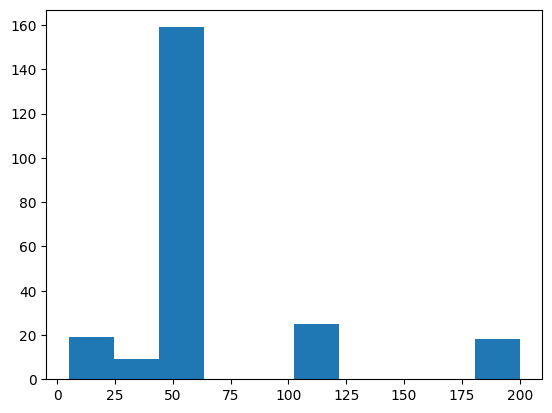

In [27]:
#df = df.dropna(subset=['back_camera_resolution'])

df['back_camera_resolution'] = df['back_camera_resolution'].str.extract(r'(\d+)').astype(float)
df['back_camera_resolution'] = df['back_camera_resolution'].fillna(df['back_camera_resolution'].median())
plt.hist(df.back_camera_resolution)

In [28]:
# Front camera & resolution

In [29]:
df.front_camera.unique()
df.front_camera = df.front_camera.map({'Single Cam': 1, 'Dual Cam': 2})

In [30]:
df['front_camera_resolution'] = df['front_camera_resolution'].str.split(' ').str[0].astype(int)
df.front_camera_resolution.isna().sum()

0

In [31]:
# Face ID & Dual Sim
df['face_id'] = df['face_id'].replace({'Igen': 1, 'Nem': 0}).fillna(0).astype(int)
df['dual_sim'] = df['dual_sim'].replace({'Igen': 1, 'Nem': 0}).fillna(0).astype(int)

In [32]:
# Width & Height & Depth
df.w = df.w.str.split(' ').str[0].astype(float)
df.h = df.h.str.split(' ').str[0].astype(float)
df.d = df.d.str.split(' ').str[0].astype(float)

df = df[df.h > 100]
df = df[df.w < 100]

#plt.hist(df.h)

In [33]:
# Mass
df.mass = df.mass.str.split(' ').str[0].astype(float)
df.loc[df['mass'] < 1, 'mass'] = df.loc[df['mass'] < 1, 'mass'] * 1000

(array([  1.,   0.,   0.,  13.,  18.,  15., 142.,   9.,  16.,  11.]),
 array([2000., 2500., 3000., 3500., 4000., 4500., 5000., 5500., 6000.,
        6500., 7000.]),
 <BarContainer object of 10 artists>)

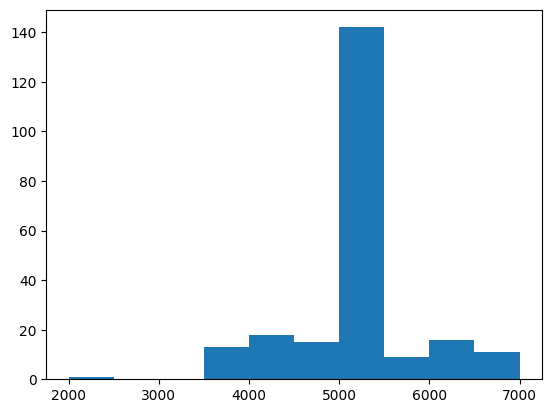

In [34]:
# Step 1: Extract numeric part and convert to float (to allow NaN)
df['battery'] = df['battery'].str.extract(r'(\d+)').astype(float)
df['battery'] = df['battery'].fillna(df['battery'].median())
plt.hist(df.battery)

In [46]:
from pycaret.regression import *
import matplotlib.pyplot as plt
import shap

# 1. Prepare the dataset for pycaret
# Specify column types:
binary_cat = ['type', 'face_id', 'dual_sim']
ordinal_cat = ['front_camera', 'back_camera']

# 2. Create train/validation/test split: 70-20-10
train_val = df.sample(frac=0.9, random_state=42)  # 90% train+val
test = df.drop(train_val.index)                  # 10% test

val = train_val.sample(frac=2/9, random_state=42)  # ~20% of total
train = train_val.drop(val.index)                   # ~70% of total

print(f"Train size: {train.shape[0]}, Validation size: {val.shape[0]}, Test size: {test.shape[0]}")

# 3. Setup PyCaret on train + validation combined (since pycaret does internal CV)
# But to tune on validation, we will first train on train, tune on validation manually.

# Combine train and validation for PyCaret setup
train_val_combined = pd.concat([train, val])

reg = setup(
    data=train_val_combined,
    target='price',
    numeric_features=['reviews', 'capacity', 'memory', 'screen_diagonal', 'pixel_w', 'pixel_h', 
                      'back_camera_resolution', 'front_camera_resolution', 'w', 'h', 'd', 'mass', 'battery'],
    categorical_features=binary_cat + ordinal_cat,
    ordinal_features={
        'front_camera': ['1', '2'],   # replace these categories with actual ordinal levels if known
        'back_camera': ['1', '2', '3', '4']    # adjust levels accordingly
    },
    normalize=True,
    session_id=42,
    html=False
)

# 4. Compare models and pick top 3 for tuning
top3 = compare_models(n_select=3)

Train size: 157, Validation size: 45, Test size: 23
                    Description             Value
0                    Session id                42
1                        Target             price
2                   Target type        Regression
3           Original data shape         (202, 19)
4        Transformed data shape         (202, 19)
5   Transformed train set shape         (141, 19)
6    Transformed test set shape          (61, 19)
7              Ordinal features                 2
8              Numeric features                13
9          Categorical features                 5
10                   Preprocess              True
11              Imputation type            simple
12           Numeric imputation              mean
13       Categorical imputation              mode
14     Maximum one-hot encoding                25
15              Encoding method              None
16                    Normalize              True
17             Normalize method            zscor

                                    Model           MAE           MSE  \
et                  Extra Trees Regressor  1.659162e+04  1.239021e+09   
gbr           Gradient Boosting Regressor  1.864553e+04  1.525195e+09   
rf                Random Forest Regressor  2.646175e+04  2.023171e+09   
dt                Decision Tree Regressor  2.231654e+04  2.344466e+09   
ada                    AdaBoost Regressor  4.190975e+04  2.744540e+09   
lightgbm  Light Gradient Boosting Machine  3.448042e+04  2.781957e+09   
ridge                    Ridge Regression  4.372654e+04  3.426527e+09   
br                         Bayesian Ridge  4.417883e+04  3.446889e+09   
lasso                    Lasso Regression  4.398220e+04  3.465496e+09   
lr                      Linear Regression  4.407151e+04  3.473732e+09   
llar         Lasso Least Angle Regression  4.406734e+04  3.473935e+09   
huber                     Huber Regressor  4.453037e+04  4.055213e+09   
knn                 K Neighbors Regressor  4.446088

Processing:   0%|                                                                                               | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
             MAE           MSE        RMSE      R2   RMSLE    MAPE
Fold                                                              
0     41076.3116  3.214152e+09  56693.4959  0.8557  0.3290  0.2575
1     36773.8293  3.344060e+09  57827.8522  0.9127  0.2778  0.2432
2     22936.3632  1.026326e+09  32036.3196  0.9704  0.2023  0.1570
3     31068.7528  1.748639e+09  41816.7369  0.9437  0.2373  0.2042
4     30192.0324  1.773111e+09  42108.3205  0.9206  0.3630  0.3201
Mean  32409.4579  2.221258e+09  46096.5450  0.9206  0.2819  0.2364
Std    6174.4000  9.053830e+08   9816.6345  0.0382  0.0585  0.0545
                   Model       MAE           MSE       RMSE      R2  RMSLE  \
0  Extra Trees Regressor  459.9056  4.530803e+06  2128.5684  0.9998  0.028   

     MAPE  
0  0.0056  
Model: ExtraTreesRegressor(n_jobs=-1, random_state=42), Validation 

Processing:   0%|                                                                                               | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


             MAE           MSE        RMSE      R2   RMSLE    MAPE
Fold                                                              
0     29495.5297  2.363302e+09  48613.8045  0.8939  0.3357  0.2086
1     18821.6265  1.231338e+09  35090.4215  0.9679  0.2102  0.1125
2     18368.9195  7.241144e+08  26909.3744  0.9791  0.1586  0.1094
3     11472.7082  2.329208e+08  15261.7420  0.9925  0.2566  0.1151
4     20100.9916  1.580231e+09  39752.1170  0.9292  0.3635  0.2445
Mean  19651.9551  1.226381e+09  33125.4919  0.9525  0.2649  0.1580
Std    5767.7257  7.289799e+08  11361.4666  0.0361  0.0763  0.0571
                         Model        MAE           MSE        RMSE      R2  \
0  Gradient Boosting Regressor  6905.3976  1.341141e+08  11580.7635  0.9955   

    RMSLE    MAPE  
0  0.0842  0.0442  
Model: GradientBoostingRegressor(random_state=42), Validation RMSE: 11580.76


Processing:   0%|                                                                                               | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
             MAE           MSE        RMSE      R2   RMSLE    MAPE
Fold                                                              
0     44890.3485  3.721032e+09  61000.2610  0.8330  0.3217  0.2586
1     35531.7650  4.152678e+09  64441.2758  0.8916  0.2010  0.1658
2     28601.3297  1.492789e+09  38636.6278  0.9569  0.1616  0.1432
3     21514.1380  1.072958e+09  32756.0447  0.9655  0.1954  0.1482
4     27008.6749  1.773018e+09  42107.2258  0.9206  0.3580  0.2724
Mean  31509.2512  2.442495e+09  47788.2870  0.9135  0.2475  0.1976
Std    8047.9546  1.247810e+09  12600.5867  0.0482  0.0774  0.0561
                     Model        MAE           MSE        RMSE      R2  \
0  Random Forest Regressor  7827.7565  1.609827e+08  12687.8959  0.9946   

    RMSLE    MAPE  
0  0.0762  0.0477  
Model: RandomForestRegressor(n_jobs=-1, random_state=42),

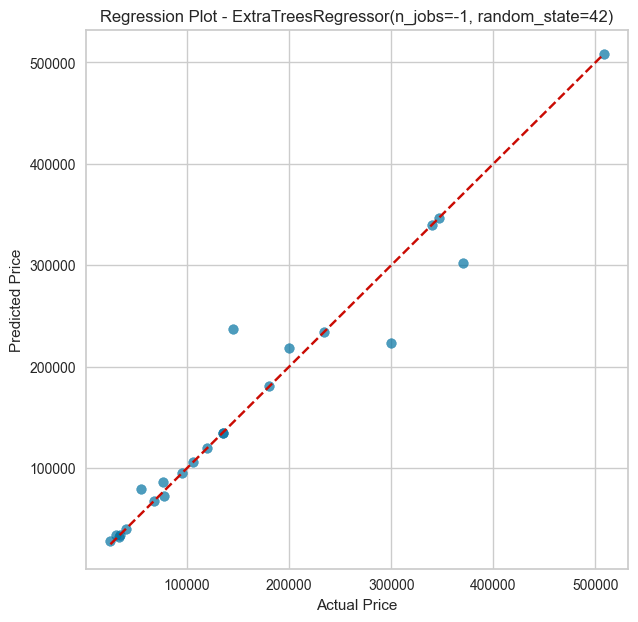

In [50]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import shap

# 4. Tune each model on TRAIN set and evaluate on VALIDATION set manually
best_model = None
best_score = float('inf')
best_model_name = ''

for model in top3:
    tuned = tune_model(model, optimize='RMSE', fold=5, n_iter=20)
    val_pred = predict_model(tuned, data=val)

    # Find the prediction column safely
    pred_col = None
    for col in ['Label', 'prediction_label', 'prediction']:
        if col in val_pred.columns:
            pred_col = col
            break
    if pred_col is None:
        pred_col = val_pred.columns[-1]  # fallback to last column

    val_rmse = mean_squared_error(val['price'], val_pred[pred_col], squared=False)
    print(f"Model: {model}, Validation RMSE: {val_rmse:.2f}")

    if val_rmse < best_score:
        best_score = val_rmse
        best_model = tuned
        best_model_name = str(model)

print(f"\nBest model: {best_model_name} with Validation RMSE: {best_score:.2f}")

# 5. Evaluate best model on TEST set
test_pred = predict_model(best_model, data=test)
pred_col = None
for col in ['Label', 'prediction_label', 'prediction']:
    if col in test_pred.columns:
        pred_col = col
        break
if pred_col is None:
    pred_col = test_pred.columns[-1]

test_rmse = mean_squared_error(test['price'], test_pred[pred_col], squared=False)
test_r2 = r2_score(test['price'], test_pred[pred_col])
print(f"Test RMSE: {test_rmse:.2f}, Test R2: {test_r2:.3f}")

# 6. Regression plot on test set
plt.figure(figsize=(7, 7))
plt.scatter(test['price'], test_pred[pred_col], alpha=0.7)
plt.plot([test['price'].min(), test['price'].max()],
         [test['price'].min(), test['price'].max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'Regression Plot - {best_model_name}')
plt.grid(True)
plt.show()




In [56]:
from pycaret.regression import save_model

save_model(best_model, 'best_model')


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['reviews', 'capacity', 'memory',
                                              'screen_diagonal', 'pixel_w',
                                              'pixel_h',
                                              'back_camera_resolution',
                                              'front_camera_resolution', 'w',
                                              'h', 'd', 'mass', 'battery'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['type', 'face_id', 'dual_sim...
                                                                          'mapping': 1      0
 2      1
 3      2
 4      3
 NaN   -1
 dtype: int64}]))),
                 ('onehot_encoding',
                  TransformerWrapper(include=['front_camera', 'back_camera'],
                           